# Machine learning to segment neutron images

<p style="font-size:1.75em;padding-bottom: 1.0em;"><b>Machine learning to segment neutron images</b></p>
<p style="font-size:1.2em;padding-bottom: 0.25em;">Anders Kaestner, Beamline scientist - Neutron Imaging</p>  
<p style="font-size:1.2em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

# Lecture outline

In this lecture about machine learning to segment neutron images we will cover the following topics

1. Introduction
2. Limited data problem
3. Unsupervised segmentation
4. Supervised segmentation
5. Final problem: Segmenting root networks using convolutional NNs
6. Future Machine learning challenges in NI

## Importing needed modules
This lecture needs some modules to run. We import all of them here.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.filters as flt
import matplotlib as mpl
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from lecturesupport import plotsupport as ps
import pandas as pd
from sklearn.datasets import make_blobs
import scipy.stats as stats
import astropy.io.fits as fits
%matplotlib inline


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'png')
#plt.style.use('seaborn')
mpl.rcParams['figure.dpi'] = 150

In [3]:
import importlib
importlib.reload(ps);

# Introduction

In this introduction part we give a starting point for the lecture. With topics like.

- Introduction to neutron imaging
  - Some words about the method
  - Contrasts
  
- Introduction to segmentation
  - What is segmentation
  - Noise and SNR
  
- Problematic segmentation tasks
  - Intro
  - Segmenation problems in neutron imaging
  

From these topics we will go into looking at how different machine learning techniques can be used to segment images. An in particular images obtained in neutron imaging experiments

## What is an image?

In this lecture we are going to analyze the contents of images, but first lets define what an image is.

A very abstract definition: 
- __A pairing between spatial information (position)__
- __and some other kind of information (value).__

In most cases this is a two- or three-dimensional position (x,y,z coordinates) and a numeric value (intensity)

In reality it can be many things like a picture, a radiograph, a matrix presentation of a raster scan and so on. In the case of volume images we are talking about volume representations like a tomography or time series like movies.

## Science and Imaging
Images are great for qualitative analyses since our brains can quickly interpret them without large _programming_ investements.

This is also the reason why image processing can be very frustrating. Seeing a feature in the image may be obvious to the human eye, but it can be very hard to write an algorithm that makes the same conclusion. In particular, when you are using traditional image processing techniques. This is an classic area for machine learning, these methods are designed and trained to recognize patterns and features in the images. Still, they can only perform well on the type of data they are trained with.

### Proper processing and quantitative analysis is however much more difficult with images.
 - If you measure a temperature, quantitative analysis is easy, $50K$.
 - If you measure an image it is much more difficult and much more prone to mistakes, subtle setup variations, and confusing analyses


### Furthermore in image processing there is a plethora of tools available

- Thousands of algorithms available
- Thousands of tools
- Many images require multi-step processing
- Experimenting is time-consuming

## Some word about neutron imaging
<figure><img src="figures/collimator.svg" style="height:400px" align="middle"></figure>

Neutron imaging is a method based on transmission of the neutron radiation through a sample, i.e. the fundamental information is a radiograph. In this sense it is very much similar to the more known x-ray imaging. The basic outline in the figure below show the components source, collimator, sample, and detector. The neutron beam is slightly divergent, but it can mostly be approximated by a parallel beam. 

```{figure} figures/collimator.pdf
---
scale: 75%
---
Schematic transmission imaging setup.
```

The intensity in a radiographic image proportional to the amount of radiation that remains after it was transmitted through the sample. The transmitted radiation is described by Beer-Lambert's law which in its basic form look like

$I=I_0\cdot{}e^{-\int_L \mu{}(x) dx}$
```{figure} figures/AttenuationLaw.pdf
---
scale: 30%
---
Transmission plot through a sample.
```

Where $\mu(x)$ is the attenuation coefficient of the sample at position _x_. This equation is a simplification as no source has a uniform spectrum and the attenuation coefficient depends on the radiation energy. We will touch the energy dispersive property in one of the segmentation examples later.

Single radiographs are relatively rare. In most experiments the radiographs are part of a time series aquisition or projections for the 3D tomography reconstuction. In this lecture we are not going very much into the details about the imaging method as such. This is a topic for other schools that are offered. 


## Neutron imaging contrast

The integral of Beer-Lambert's law turns into a sum for simple material compositions like in the sample in the figure below

```{figure} figures/porous_media_sand.pdf
---
scale: 50%
---
The transmission through a sample can be divied into contributions for each material.
```

The amount of radiation passing through the sample depends on the attenuation coefficients which are material and radiation specific. The periodic systems below illustrate how diffent elements attenuate for neutrons and X-rays

```{figure} figures/Periodic_table_neutron.pdf
---
scale: 75%
---
Attenuation coefficients for thermal neutrons.
```

```{figure} figures/Periodic_table_Xray.pdf
---
scale: 75%
---
Attenuation coefficients for X-rays.
```

<table style="width:100%">
    <tr>
    <td><img src="figures/porous_media_sand.svg" width="300px"/></td>
    <td><img src="figures/Periodic_table_Xray.svg" width="300px"/></td>
    <td><img src="figures/Periodic_table_neutron.svg" width="300px"/></td>
  </tr></table>

## Measurements are rarely perfect
<figure><img src="figures/imperfect_imaging_system.svg" style="height:400px" align="middle"></figure>

There is no perfect measurement. This is also true for neutron imaging. The ideal image is the sample is distorted for many reasons. The figure below shows how an image of a sample can look after passing though the acquisition system. These quailty degradations will have an impact on the analysis of the image data. In some cases, it is possible to correct for some of these artifacts using classing image processing techniques. There are however also cases that require extra effort to correct the artifacts.  

```{figure} figures/imperfect_imaging_system.pdf
---
scale: 75%
---
Schematic showing the error contributions in an imperfect imaging system.
```

### Factors affecting the image quality

The list below provides some factors that affect the quality of the acquired images. Most of them can be handled by changing the imaging configuration in some sense. It can however be that the sample or process observed put limitiations on how much the acquisition can be tuned to obtain the perfect image.

* Resolution (Imaging system transfer functions)
* Noise
* Contrast
* Inhomogeneous contrast
* Artifacts

#### Resolution
The resolution is primarily determined optical transfer function of the imaging system. The actual resolution is given by the extents of the sample and how much the detector needs to capture in one image. This gives the field of view and given the number pixels in the used detector it is possible to calculate the pixel size. The pixel size limits the size of the smallest feature in the image that can be detected. The scintillator, which is used to convert neutrons into visible light, is chosen to 
1. match the sampling rate given by the pixel size.
2. provide sufficient neutron capture to obtain sufficient light output for a given exposure time.

#### Noise
An imaging system has many noise sources, each with its own distribution e.g.
1. Neutron statistics - how many neutrons are collected in a pixel. This noise is Poisson distributed. 
2. Photon statistics - how many photons are produced by each neutron. This noise is also Poisson distributed.
3. Thermal noise from the electronics which has a Gaussian distribution.
4. Digitation noise from converting the charges collected for the photons into digital numbers that can be transfered and stored by a computer, this noise has a binominal distribution.

The neutron statistics are mostly dominant in neutron imaging but in some cases it could also be that the photon statistics play a role. 

#### Contrast
The contrast in the sample is a consequence of 
1. how well the sample transmits the chosen radiation type. For neutrons you obtain good contrast from materials containing hydrogen or lithium while many metals are more transparent.
2. the amount of a specific element or material represented in a unit cell, e.g. a pixel (radiograph) or a voxel (tomography). 

The objective of many experiments is to quantify the amount of a specific material. This could for example be the amount of water in a porous medium.

Good contrast between different image features is important if you want to segment them to make conclusions about the image content. Therefore, the radiation type should be chosen to provide the best contrast between the features.

#### Inhomogeneous contrast
The contrast in the raw radiograph depends much on the beam profile. These variations are easily corrected by normalizing the images by an open beam or flat field image. 

- __Biases introduced by scattering__ Scattering is the dominant interaction for many materials use in neutron imaging. This means that neutrons that are not passing straight though the sample are scattered and contribute to a background cloud of neutrons that build up a bias of neutron that are also detected and contribute to the 

- __Biases from beam hardening__ is a problem that is more present in x-ray imaging and is caused by that fact that the attenuation coefficient depends on the energy of the radiation. Higher energies have lower attenuation coefficient, thus will high energies penetrate the thicker samples than lower energies. This can be seen when a polychromatic beam is used. 

#### Artifacts
Many images suffer from outliers caused by stray rays hitting the detector. Typical artefacts in tomography data are
- Lines, which are caused by outlier spots that only appear in single projections. These spot appear as lines in the reconstructed images.
- Rings are caused by stuck pixels which have the same value in a projections.

## Introduction to segmentation

The basic task of segmentation is to identify regions of pixels with similar properties. This can be on different levels of abstraction. The lowest level is to create segments of pixels based on their pixel values like in the LANDSAT image below.  
```{figure} figures/landsat_example.pdf
---
scale: 50%
---
Segmentation of a satelite image to identify different land types.
```

This type of segmentation is often done with the help of a histogram that shows the distribution of values in the image.

<figure><img src="figures/landsat_example.svg"/></figure>

### Basic segmentation: Applying a threshold to an image
Start out with a simple image of a cross with added noise

$$ I(x,y) = f(x,y) $$

Here, we create a test image with two features embedded in uniform noise; a cross with values in the order of '1' and background with values in the order '0'. The figure below shows the image and its histogram. The histogram helps us to see how the graylevels are distributed which helps to decide where to put a threshold that segments the cross from the background.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(7,3))
nx = 5; ny = 5;
xx, yy = np.meshgrid(np.arange(-nx, nx+1)/nx*2*np.pi, 
                     np.arange(-ny, ny+1)/ny*2*np.pi)
cross_im =   1.5*np.abs(np.cos(xx*yy))/(np.abs(xx*yy)+(3*np.pi/nx)) + np.random.uniform(-0.25, 0.25, size = xx.shape)
im=ax[0].imshow(cross_im, cmap = 'hot'); 
ax[1].hist(cross_im.ravel(),bins=10);

### Applying a threshold to an image

By examining the image and probability distribution function, we can _deduce_ that the underyling model is a whitish phase that makes up the cross and the darkish background

Applying the threshold is a deceptively simple operation

$$ I(x,y) = 
\begin{cases}
1, & f(x,y)\geq0.40 \\
0, & f(x,y)<0.40
\end{cases}$$


In [ ]:
threshold = 0.4; thresh_img = cross_im > threshold

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(cross_im, cmap = 'hot', extent = [xx.min(), xx.max(), yy.min(), yy.max()])
ax[0].plot(xx[np.where(thresh_img)]*0.9, yy[np.where(thresh_img)]*0.9,
           'ks', markerfacecolor = 'green', alpha = 0.5,label = 'Threshold', markersize = 15); ax[0].legend(fontsize=8);
ax[1].hist(cross_im.ravel(),bins=10); ax[1].axvline(x=threshold,color='r',label='Threshold'); ax[1].legend(fontsize=8);


## Noise and SNR

Any measurement has a noise component and this noise has to be dealt with in some sense when the image is to be segmented. In the noise is not handled correctly it will cause many misclassified pixels. The noise strength of measured using the signal to noise ratio __SNR__. It is defined as the ratio between signal average and signal standard deviation. 

The noise in neutron imaging mainly originates from the amount of captured neutrons. This noise is Poisson distributed and the signal to noise ratio is

$$SNR=\frac{E[x]}{s[x]}\sim\frac{N}{\sqrt{N}}=\sqrt{N}$$

where _N_ is the number of captured neutrons. The figure below shows two neutron images acquired at 0.1s and 10s respectively. The plot shows the signal to noise ratio for different exposure times. 
```{figure} figures/snrhanoi.pdf
---
scale: 75%
---
Signal to noise ratio for radiographies acqired with different exposure times.
```


<figure><img src="figures/snrhanoi.svg" width="800px"></figure>

## Problematic segmentation tasks

Segmentation is rarely an obvious task. What you want to find is often obscured by other image features and unwanted artefacts from the experiment technique. If you take a glance at the painting by Bev Doolittle, you quickly spot the red fox in the middle. Looking a little closer at the painting, you'll recognize two indians on their spotted ponies. This example illustrates the problems you will encounter when you start to work with image segmentation.
```{figure} figures/doolittle_woodlandencounter.png
---
scale: 75%
---
Cases making the segmentation task harder than just applying a single thresshold.
```

<figure><img src="figures/doolittle_woodlandencounter.png" /></figure>

_Woodland Encounter_ Bev Doolittle

### Typical image features that makes life harder

The basic segmentation shown in the example above can only be used under good conditions when the classes are well separated. Images from many experiments are unfortunately not well-behaved in many cases. The figure below shows four different cases when an advanced technique is needed to segment the image. Neutron images often show a combination of all cases. 
```{figure} figures/trickycases.pdf
---
scale: 75%
---
Cases making the segmentation task harder than just applying a single thresshold.
```

The impact on the segmentation performance of all these cases can be reduced by proper experiment planning. Still, sometimes these improvements are not fully implemented in the experiment to be able to fulfill other experiment criteria.  

<figure><img src='figures/trickycases.svg' height="500px"/></figure>

## Segmenation problems in neutron imaging

# Limited data problem

Machine learning methods require a lot of training data to be able to build good models that are able to detect the features they are intended to. 

_Different types of limited data_:
- Few data points or limited amounts of images

This is very often the case in neutron imaging. The number of images collected during an experiment session is often very low due to the long experiment duration and limited amount of beam time. This makes it hard to develop segmentation and analysis methods for single experiments. The few data points problem can partly be overcome by using data from previous experiment with similar characteristics.

- Unbalanced data

Unbalanced data means that the ratio between the data points with features you want detect and the total number data points is several orders of magnitude. E.g roots in a volume like the example we will look at later in this lecture. There is even a risk that the distribution of the wanted features is overlapped by the dominating background distribution.
```{figure} figures/classunbalance.pdf
---
scale: 100%
---
Two cases of unblanaced data; (a) the classes are well separated and the feature class is clearly visible in the tail distribution of the background and (b) the feature class is embeded in the background making it hard to detect.
```
Case (a) can most likely be segmented using one of the many histogram based thresholding methods proposed in literature.

<figure><img src="figures/classunbalance.svg"></figure>

- Little or missing training data

A complete set of training data contains both input data and labelled data. The input data is easy to obtain, it is the images you measured during your experiment. The labelled data is harder to get as it is a kind of chicken and egg problem. In particular, if your experiment data is limited. In that case, you would have to mark-up most of the available data to obtain the labeled data. Which doesn't make sense because 
- then you'd already solved the task before even starting to train your segmentation algorithm. 
- An algorithm based on learning doesn't improve the results, it only make it easier to handle large amounts of data.

## Training data from NI is limited

In the introducing words about  we essentially described the problems that arise in neutron imaging. 

## Augmentation

## Transfer learning

# Unsupervised segmentation

## Introducing clustering

With clustering methods you aim to group data points together into a limited number of clusters. Here, we start to look at an example where each data point has two values. The test data is generated using the ```make_blobs``` function.

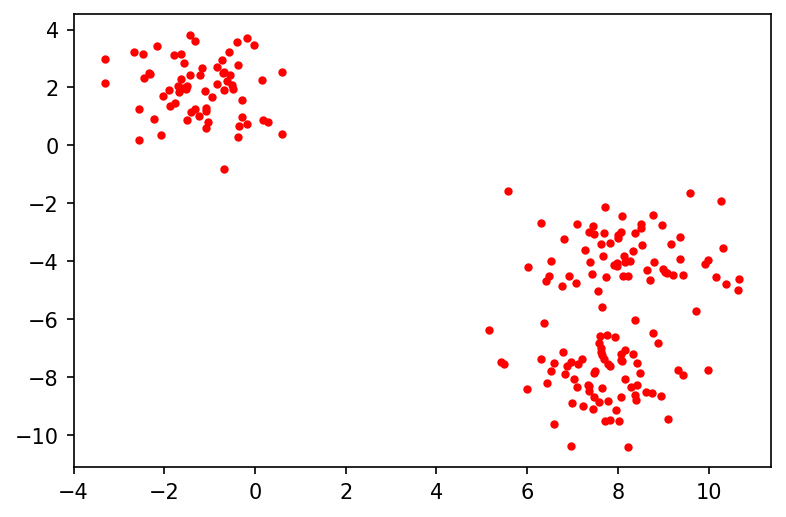

In [6]:
test_pts = pd.DataFrame(make_blobs(n_samples=200, random_state=2018)[
                        0], columns=['x', 'y'])
plt.plot(test_pts.x, test_pts.y, 'r.');

The generated data set has two obvoius clusters, but if look closer it is even possible to identify three clusters. We will now use this data to try the k-means algorithm.

## k-means

The k-means algorithm is one of the most used unsupervised clustering method. The user only have to provide the number of classes the algorithm shall find. 
__Note:  If you look for N groups you will always find N groups with K-Means, whether or not they make any sense__

It is an iterative method that starts with a label image where each pixel has a random label assignment. Each iteration involves the following steps:
1. Compute current centroids based on the o current labels
2. Compute the value distance for each pixel to the each centroid. Select the class which is closest. 
3. Reassign the class value in the label image.
4. Repeat until no pixels are updated.

The distance from pixel _i_ to centroid _j_ is usually computed as $||p_i - c_j||_2$.

It is important to note that k-means by definition is not position sensitive. The position can however be included as additional components in the data vectors.

k-means makes most sense to use on vector valued images where each pixel is represented by several values, e.g.:
1. Images from multimodal experiments like combined neutron and X-ray.
2. Wavelength resolved imaging 


## Basic clustering example

In this example we will use the blob data we previously generated and to see how k-means behave when we select different numbers of clusters.

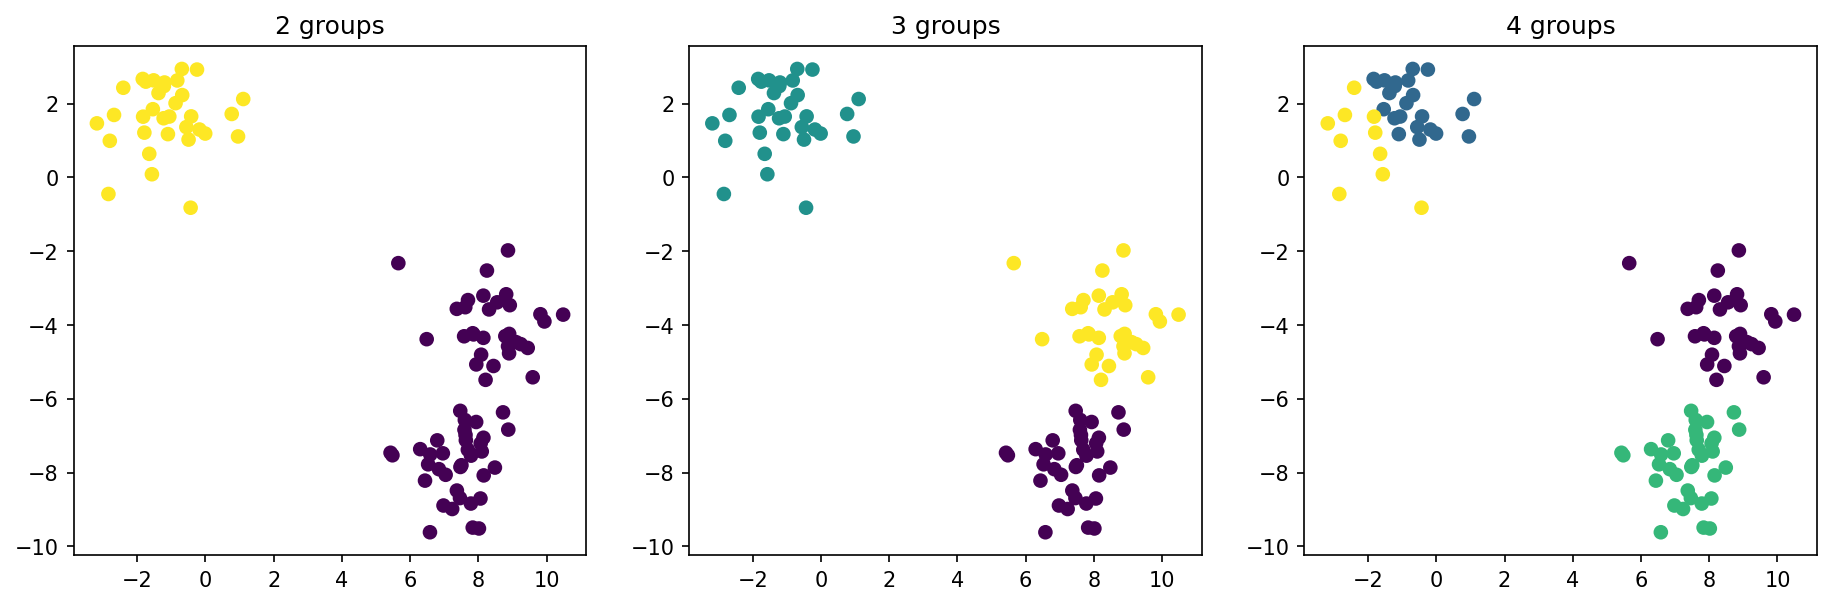

In [5]:
fig, ax = plt.subplots(1,3,figsize=(15,4.5))

for i in range(3) :
    km = KMeans(n_clusters=i+2, random_state=2018); n_grp = km.fit_predict(test_pts)
    ax[i].scatter(test_pts.x, test_pts.y, c=n_grp)
    ax[i].set_title('{0} groups'.format(i+2))

When we select two clusters there is a natural separation between the two clusters we easily spotted by just looking at the data. When the number of clusters is increased to three, we again see a cluster separation that makes sense. Now, when the number of clusters is increased yet another time we see that one of the clusters is split once more. This time it is how ever questionable if the number of clusters makes sense. From this example, we see that it is important to be aware of problems related to over segmentation.

## Clustering applied to wavelength resolved imaging

### The imaging techniques and its applications

### The data

In this example we use a time of flight transmission spectrum from an assembly of six rectangular steel blocks produced by means of additive manufactoring. The typical approach to analyse this kind of information is to select some regions of interest and compute the average spectra from these regions. The average spectra are then analyzed using single Bragg edge fitting methods or Rietveld refinement. 

Here, we will explore the posibility to identify regions with similar spectra using k-means clustering. The data is provided on the repository and has the dimensions 128x128x661, where the first to dimensions reflect the image size and the last is th number of time bins of the time of flight spectrum. This is a downsized version of the original data which has 512x512 image frames. Each frame has a relatively low signal to noise ratio, therefore we use the average image _wtof_ to show the image contents.

In [ ]:
tof  = np.load('../data/tofdata.npy')
wtof = tof.mean(axis=2)
plt.imshow(wtof);

#### Reshaping 

The k-means requires vectors for each feature dimension, not images as we have in this data set. Therefore, we need to reshape our data. The reshaping is best done using the numpy array method ```reshape``` like this:

In [ ]:
tofr=tof.reshape([tof.shape[0]*tof.shape[1],tof.shape[2]])
print("Input ToF dimensions",tof.shape)
print("Reshaped ToF data",tofr.shape)

The reshaped data _tofr_ now has the dimensions 16384x661, i.e. each 128x128 pixel image has been replaced by a vector with the length 16384 elements. The number of time bins still remains the same. The ```reshape```method is a cheap operation as it only changes the elements of the dimension vector and doesn't rearrange the data in memory. 

### Setting up and running k-means

When we set up k-means, we merely have to select the number of clusters. The choice depends on many factors. Particularly in this case with data points containing a large number of values we have a great degree of freedom in what could be considered the correct result. Thus we should ask ourselves what we expect from the clustering.

- We can clearly see that there is void on the sides of the specimens.
- There is also a separating band between the specimens.
- Finally we have to decide how many regions we want to find in the specimens. Let's start with two regions with different characteristics.

In [ ]:
km = KMeans(n_clusters=4, random_state=2018)
c  = km.fit_predict(tofr).reshape(tof.shape[:2]) # Label image
kc = km.cluster_centers_.transpose()             # cluster centroid spectra

__Results from the first try__

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(18,5)); axes=axes.ravel()
axes[0].imshow(wtof,cmap='viridis'); axes[0].set_title('Average image')
p=axes[1].plot(kc);                  axes[1].set_title('Cluster centroid spectra'); axes[1].set_aspect(tof.shape[2], adjustable='box')
cmap=ps.buildCMap(p) # Create a color map with the same colors as the plot

im=axes[2].imshow(c,cmap=cmap); plt.colorbar(im);
axes[2].set_title('Cluster map');
plt.tight_layout()

This result was not very convincing... 

### We need more clusters

- Experiment data has variations on places we didn't expect k-means to detect as clusters. 
- We need to increase the number of clusters!

What happens when we increase the unmber of clusters to ten? 

In [ ]:
km = KMeans(n_clusters=10, random_state=2018)
c  = km.fit_predict(tofr).reshape(tof.shape[:2]) # Label image
kc = km.cluster_centers_.transpose()             # cluster centroid spectra

#### Results of k-means with ten clusters

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(18,5)); axes=axes.ravel()
axes[0].imshow(wtof,cmap='viridis'); axes[0].set_title('Average image')
p=axes[1].plot(kc);                  axes[1].set_title('Cluster centroid spectra'); axes[1].set_aspect(tof.shape[2], adjustable='box')
cmap=ps.buildCMap(p) # Create a color map with the same colors as the plot

im=axes[2].imshow(c,cmap=cmap); plt.colorbar(im);
axes[2].set_title('Cluster map');
plt.tight_layout()

#### Interpreting the clusters

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(14,5)); axes=axes.ravel()
axes[0].matshow(np.corrcoef(kc.transpose()))
axes[1].plot(kc); axes[1].set_title('Cluster centroid spectra'); axes[1].set_aspect(tof.shape[2], adjustable='box')

# Supervised segmentation
-	e.g. k-NN, decision trees
-	NNs for segmentation

<figure><img src="figures/forest.svg"></figure>

## Create example data for supervised segmentation

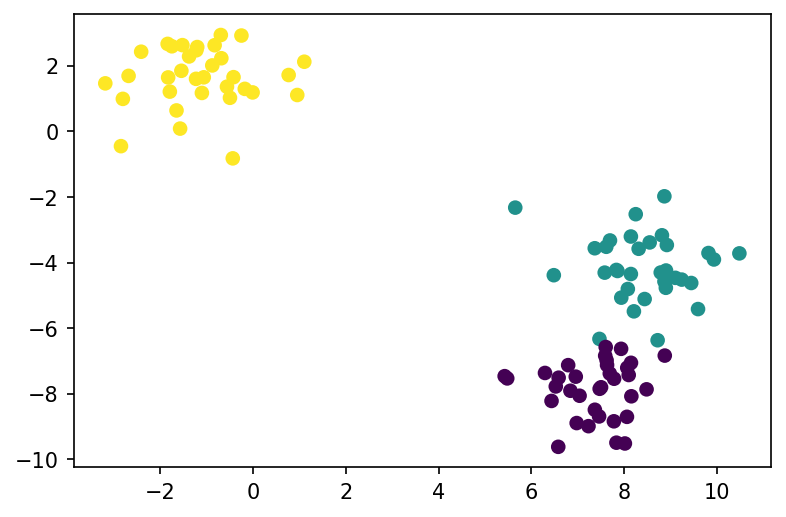

In [4]:
blob_data, blob_labels = make_blobs(n_samples=100, random_state=2018)
test_pts = pd.DataFrame(blob_data, columns=['x', 'y'])
test_pts['group_id'] = blob_labels
plt.scatter(test_pts.x, test_pts.y,
            c=test_pts.group_id,
            cmap='viridis');

## Example - Detecting and correcting unwanted outliers (a.k.a. spots) in neutron images

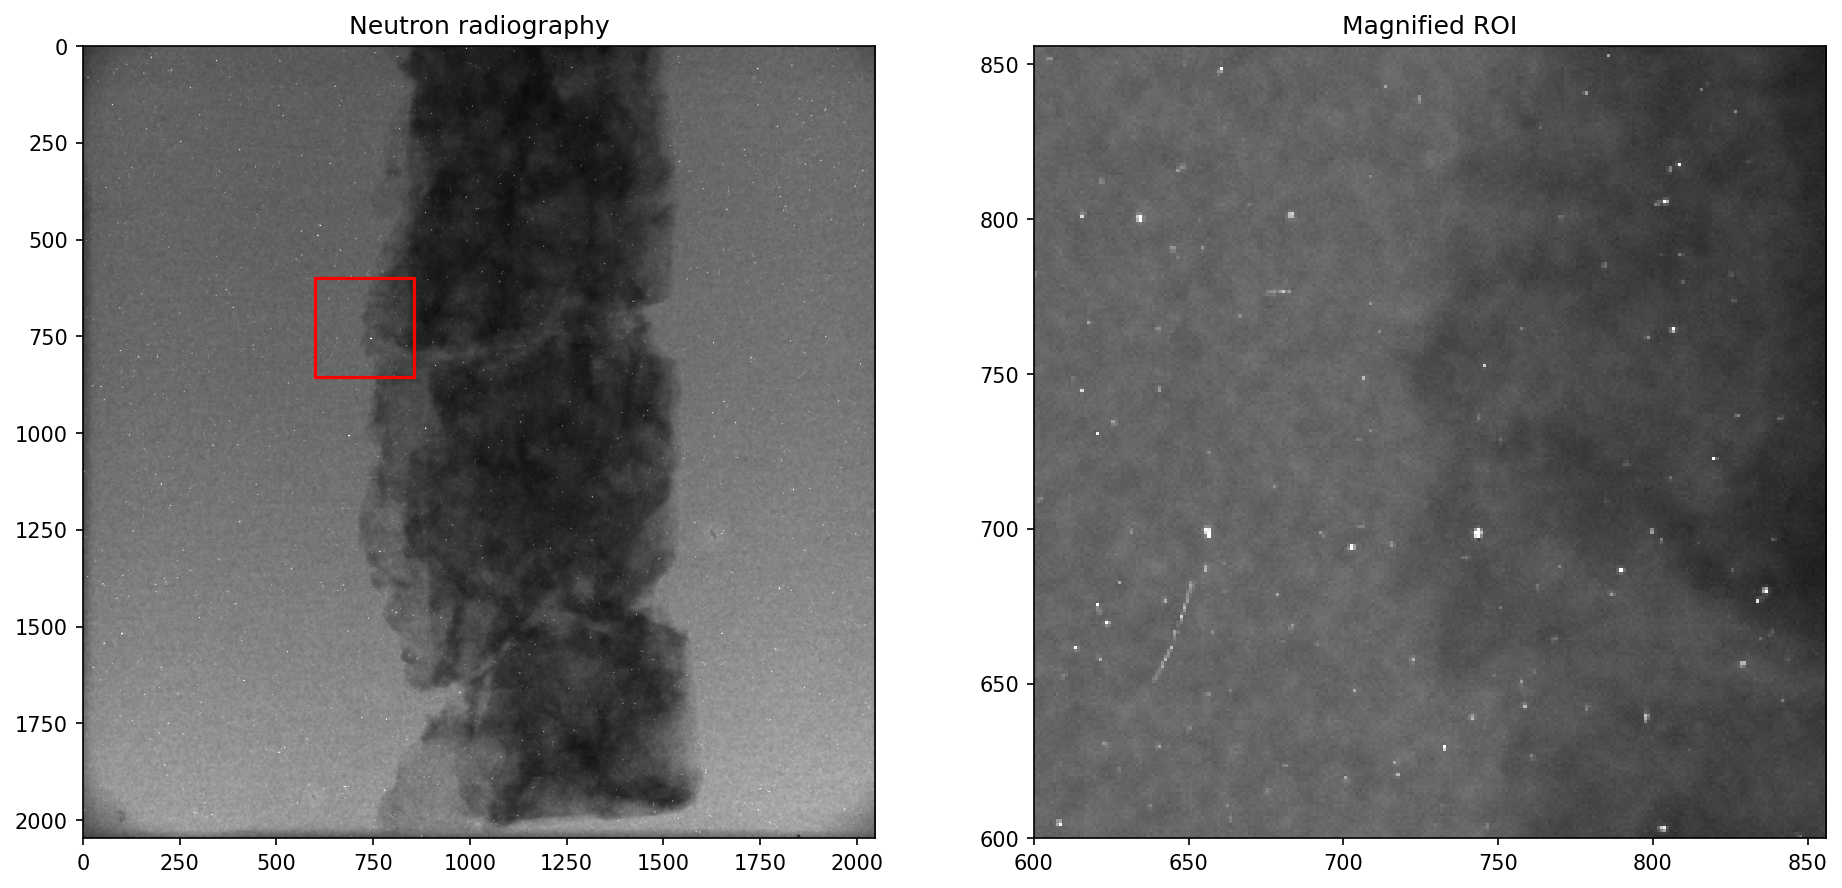

In [7]:
orig= fits.getdata('../data/spots/mixture12_00001.fits')
r=600; c=600; w=256
ps.magnifyRegion(orig,[r,c,r+w,c+w],[15,7],vmin=400,vmax=4000,title='Neutron radiography')

### Marked-up spots

```{figure} figures/markedspots.pdf
---
scale: 100%
---
Two cases of unblanaced data; (a) the classes are well separated and the feature class is clearly visible in the tail distribution of the background and (b) the feature class is embeded in the background making it hard to detect.
```

<figure><img src='figures/markedspots.svg'/></figure>

### Baseline - Traditional spot cleaning algorithm

```{figure} figures/spotclean_algorithm.pdf
---
scale: 100%
---
Schematic description of the spot cleaning baseline algorithm
```


<figure><img src="figures/spotclean_algorithm.svg" style="height:400px" align="middle"></figure>

__Parameters__

- _N_ Width of median filter.
- _k_ Threshold level for outlier detection.

### The spot cleaning algorithm

The baseline algorithm is here implemented as a python function that we will use when we compare the performance of the CNN algorithm. This is the most trivial algorithm for spot cleaning and there are plenty other algorithms to solve this task.  

In [16]:
def spotCleaner(img, threshold=0.95, selem=np.ones([3,3])) :
    mimg = flt.median(img,selem=selem)
    timg = np.abs(img-mimg) < threshold
    cleaned = img * timg + mimg * (1-timg)
    return (cleaned,timg)

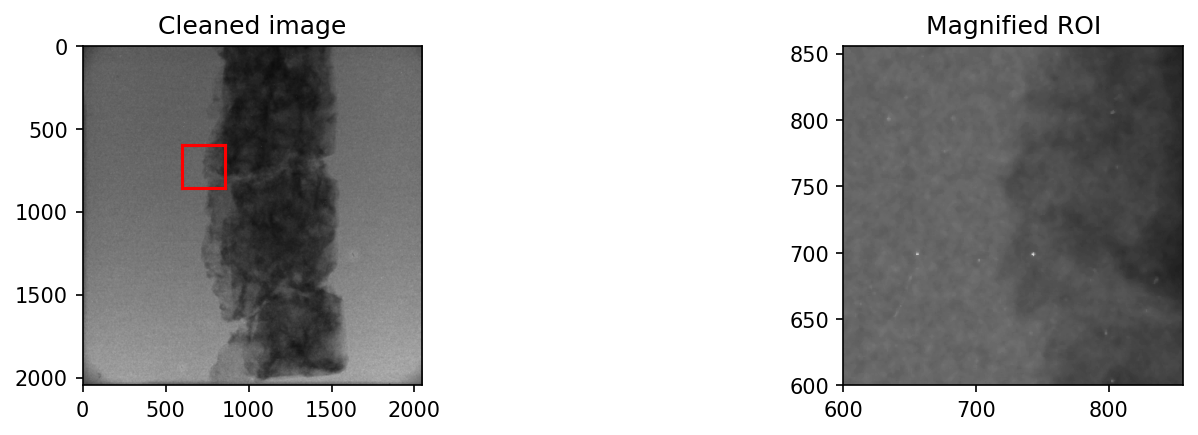

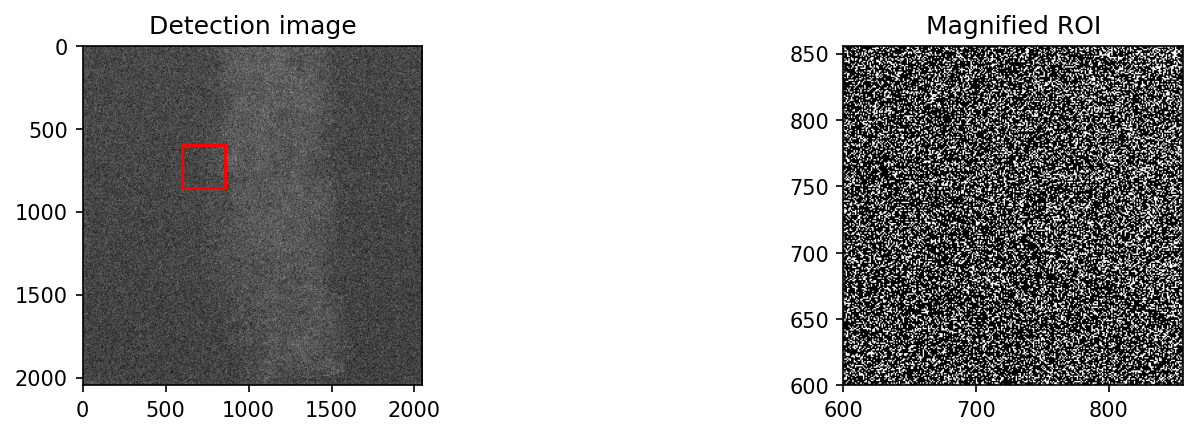

In [24]:
baseclean,timg = spotCleaner(orig,threshold=20)
ps.magnifyRegion(baseclean,[r,c,r+w,c+w],[12,3],vmin=400,vmax=4000,title='Cleaned image')
ps.magnifyRegion(timg,[r,c,r+w,c+w],[12,3],vmin=0,vmax=1,title='Detection image')

# Convolutional neural networks for segmentation

### Training data
We have two choices:
1. Use real data
    - requires time consuming markup to provide training data
    - corresponds to real life images
2. Synthesize data
    - flexible and provides both 'dirty' data and ground truth.
    - model may not behave as real data

### Build a CNN for spot detection and cleaning

### Performance evaluation
Any analysis system must be verified

For this we need to split our data into three categories:
1. Training data
2. Test data
3. Validation data

# Final problem: Segmenting root networks in the rhizosphere using convolutional NNs
-	Problem definition
-	NN model
-	Loss functions
-	Training
-	Results

# Future Machine learning challenges in neutron imaging

# Concluding remarks